In [106]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp, simps
import os

# path = r'C:\Users\fgbse\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift'
path = r'C:\Users\Finley Giles-Book\Heriot-Watt University Team Dropbox\RES_EPS_Quantum_Photonics_Lab\Experiments\Current Experiments\Visible Quantum Memory\GEM and Stark shift\20240815_GEM_MBE_sims'

(200, 5)

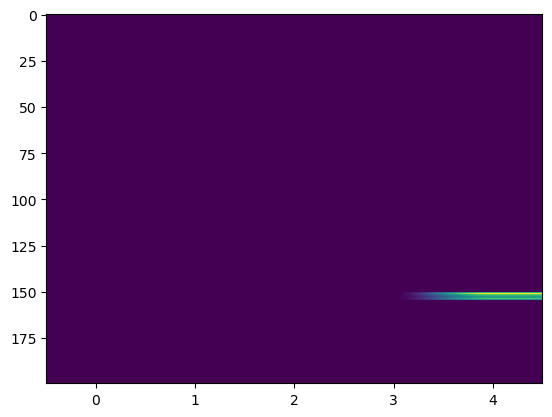

In [110]:
E = np.load(os.path.join(path,'E.npy'))
# E = np.rot90(E.T)

plt.imshow(abs(E),aspect='auto')
np.shape(E)

In [29]:
def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape/max(1/((np.pi * (lw)*(1 + ((delta)/(lw))**2))))

def lorentz(x,delta,lw,grad,stark,length):
    line_shape = 1/((np.pi * (lw + grad*length/2*stark)*(1 + ((delta + grad*stark*x)/(lw + grad*length/2*stark))**2)))
    return line_shape

def lorentz_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/(2*np.pi) * (lw + grad*length/2*stark)/((delta + grad*stark*x)**2 + (1/2*(lw + grad*length/2*stark))**2)
    return OD*line_shape/max(1/(2*np.pi) * lw/(delta**2 + (1/2*lw)**2))

def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def gauss_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = 1/((lw + grad*length/2*stark)*np.sqrt(2*np.pi)) * np.exp(-1/2 * (delta + grad*stark*x)**2/(lw + grad*length/2*stark)**2)
    return OD*line_shape/max(1/(lw*np.sqrt(2*np.pi)) * np.exp(-1/2 * delta**2/lw**2))

def grad_switch(t,t_switch):
    if t > t_switch:
        return 1
    else:
        return -1
    
def gauss(t,t_peak,amp,sigma):    
    line_shape = amp*np.exp(-(t - t_peak)**2 / (2 * sigma**2))
    return line_shape

def MBE_pol_z0(t, alpha, t0, A, sigma, delta, x, grad, stark, t_switch, g, gamma, w):

    E = gauss(t,t0,A,sigma)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x)*alpha - (1j) * g * w * E

    return dalpha_dt

def interpolate_E_t(E,t_arr,tn):

    interp = np.interp(tn,t_arr,E)
    return interp

def interpolate_E_z(E,x_arr,xn):

    interp = np.interp(xn,x_arr,E)
    return interp

def MBE_pol_z(t, alpha, E, t_arr, delta, x_n, grad, stark, t_switch, g, gamma, w):
    
    Ez = interpolate_E_t(E,t_arr,t)

    dalpha_dt = -(gamma/2)*alpha - (1j) * (delta + grad * stark * grad_switch(t_switch,t) * x_n)*alpha - (1j) * g * w * Ez

    return dalpha_dt

def MBE_field(x, E, delta, t0, t1, alpha0, E0, t_arr, x_arr, grad, stark, t_switch, g, gamma, w0, OD, lw, L):

    # Calculate the optical field over dz
    # Since the the function calculates the spatial derivative of 
    # E and the eqn does not include any terms with E then then initial value of E is not needed
    # rhs_int is the initial value

    # E1 = E0-E[:,0]*np.log(-OD)
    # E1 = E0-E[:,0]
    # E1 = E0
    # E1 = E[:,0]
    E1 = E0*np.exp(-OD*x/L)

    # print(np.shape(E[:,0]))

    sol_alpha_z = solve_ivp(MBE_pol_z,
                            (t0, t1),
                            alpha0,
                            args=(E1, t_arr, delta, x, grad, stark, t_switch, g, gamma, w0),
                            t_eval=t_arr,
                            dense_output=True,
                            vectorized=False,
                            method='RK23')
        
    alpha = sol_alpha_z.y.T

    dE_dx = -simps(rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L)*alpha,x=delta,axis=1)

    print(x)

    return dE_dx

In [35]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 0.01#0.01#0.31                            # Polarization decay rate
g = 2000#2000#406                                 # Transition coupling strength
t_input = 5                                  # Gaussian pulse peak time
sigma = 2/np.sqrt(2*np.log(2))        # Gaussian pulse sigma
OD = 0.1                                  # Optical depth used in Lorentzian
grad = 5E5#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.1                                  # Zero field absorption linewidth
t_switch = 15                            # Gradient direction switch time
A = 3.5e-3#3                              # Electric field magnitude
L = 16475/2                               # Optical path length
t_total = 50
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 200          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 200            # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 200
delta_range = 10  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

alpha = np.zeros((Nd, Nt, Nx), dtype=np.complex128)
E = np.zeros((Nt, Nx), dtype=np.complex128)
P = np.zeros((Nt, Nx), dtype=np.complex128)


In [91]:
np.size(np.linspace(-1,1,10))

10

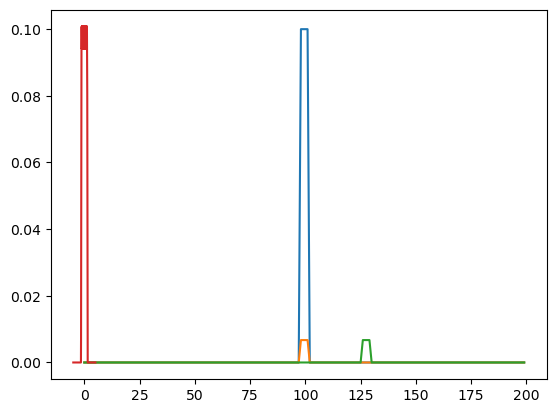

In [102]:
def rect_abs_prof(x,delta,lw,OD,grad,stark,length):
    line_shape = np.where(abs(delta + grad*stark*x) <= (lw + grad*length/2*stark), OD*lw/(lw + grad*length/2*stark), 0)
    return line_shape

def rect_abs_prof_1(x,delta,lw,OD,grad,stark,length):

    line_shape = np.where(abs(delta + grad*stark*x) <= (lw), OD*lw/(lw + grad*length/2*stark), 0)

    return line_shape

i = 0
plt.plot(rect_abs_prof(x_arr,delta,lw,OD,0,stark,L))
plt.plot(rect_abs_prof_1(x_arr,delta,lw,OD,grad,stark,L))
plt.plot(rect_abs_prof_1(x_arr[0],delta,lw,OD,grad,stark,L))

CRIB = np.zeros((Nd,Nx))

for i in range(Nx):
    CRIB[:,i] = rect_abs_prof_1(x_arr[i],delta,lw,OD,grad,stark,L)

plt.plot(delta,np.sum(CRIB,axis=1))

ValueError: x and y must have same first dimension, but have shapes (200,) and (1,)

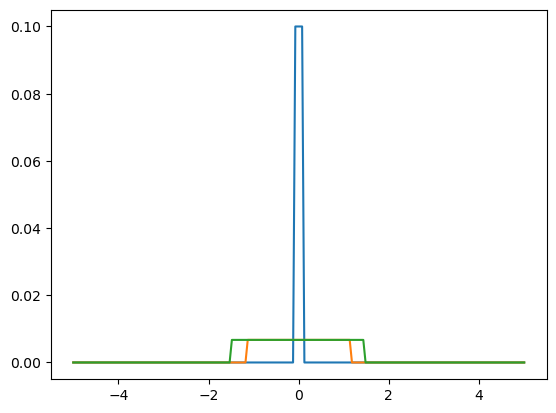

In [50]:
i = 100
plt.figure()
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,0,L),label='unbroadened')
plt.plot(delta,rect_abs_prof(x_arr,delta,lw,OD,grad,stark,L),label='broadened')
plt.plot(delta,rect_abs_prof(x_arr[i],delta,lw,OD,grad,stark,L),label='single detuning')
plt.plot(delta,np.sum(rect_abs_prof(x_arr,delta,lw,OD/len(x_arr),grad,stark,L)))
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()

In [ ]:
plt.subplot(2,1,1)
plt.imshow(abs(E),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid E \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(E),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(E),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(E)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'optical field'))

plt.figure()
# alpha_sum = np.rot90(np.sum(alpha, axis=0))
alpha_sum = np.sum(alpha, axis=0)
plt.subplot(2,1,1)
plt.imshow(abs(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid \alpha \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(alpha_sum),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(\alpha)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'atomic polarization'))

plt.figure()
plt.subplot(2,1,1)
plt.imshow(abs(P),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\mid P \mid$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,3)
plt.imshow(np.real(P),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Re(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.subplot(2,2,4)
plt.imshow(np.imag(P),extent=[t0, t1, x0, x1],aspect='auto')
plt.title(r'$\Im(P)$')
plt.xlabel(r'$t$')
plt.ylabel(r'$z$')
plt.savefig(os.path.join(path,r'polarization density'))

plt.figure()
plt.plot(lorentz(x_arr,delta,lw,grad,stark,L),label='broadened')
plt.plot(lorentz(x_arr,delta,lw,grad,0,L),label='unbroadened')
plt.xlabel(r'$\Delta$')
plt.ylabel(r'OD (A.U.)')
plt.title('Controlled Reversible Inhomogeneous Broadening')
plt.legend()
plt.savefig(os.path.join(path,r'controlled reversible inhomogeneous broadening'))

# myTeamsMessage = pymsteams.connectorcard("https://heriotwatt.webhook.office.com/webhookb2/36c66bd3-00f2-4593-9e53-9c5f95266f6b@6c425ff2-6865-42df-a4db-8e6af634813d/IncomingWebhook/bfb3c210c4e246a0b921828743844f4c/7c7eb11d-34da-4e09-abca-fcaefc441bad")
# myTeamsMessage.text("Neutroooooooooon, your simulations are done NERD!")
# myTeamsMessage.send()

(50,)


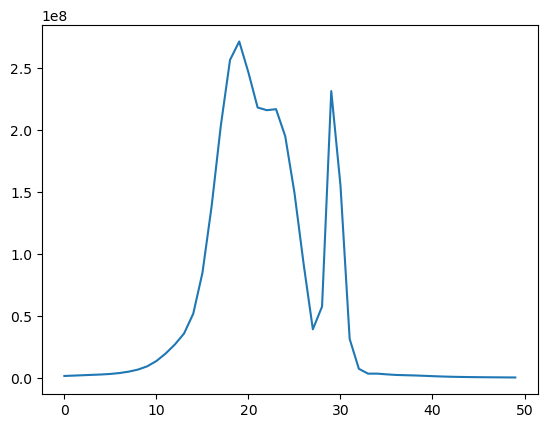

In [24]:
i = 49

CRIB = lorentz(x_arr[i],delta,lw,grad,stark,L)
A = alpha[i,:,:]

# plt.subplot(1,4,1)
# plt.plot(CRIB)

# plt.subplot(1,4,2)
# plt.imshow(abs(A))
# plt.subplot(1,4,3)
# plt.imshow(np.imag(A))
# plt.subplot(1,4,4)
# plt.imshow(np.real(A))

plt.plot(abs(simps(CRIB*A,axis=0)))
# plt.imshow(abs(CRIB*A))
print(np.shape(simps(CRIB*A,axis=0)))

P1 = np.zeros((Nx,Nt))

for i in range(Nx):
    P1


c:\Users\Finley Giles-Book\anaconda3\envs\GEM_venv\Lib\site-packages\matplotlib\cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Finley Giles-Book\anaconda3\envs\GEM_venv\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


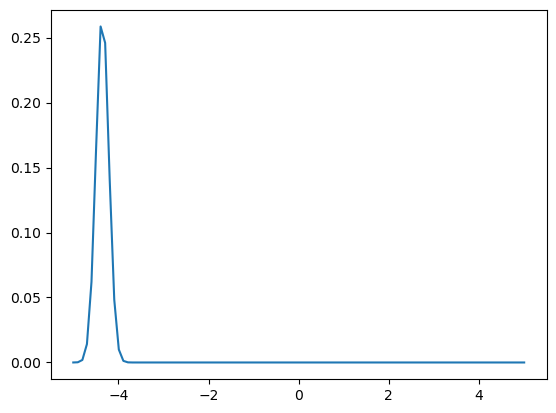

In [28]:
# Parameters - converted assuming that k0/2e0 = lambda (wavelength) = 1

gamma = 0.01#0.31                            # Polarization decay rate
g = 2000#406                                 # Transition coupling strength
t_input = 2                                  # Gaussian pulse peak time
sigma = 0.5/np.sqrt(2*np.log(2))        # Gaussian pulse sigma
OD = 1                                  # Optical depth used in Lorentzian
grad = 3e8#7.37e-11                         # Electric field gradient
stark = 6.74e-10                        # Stark coefficient
lw = 0.01                                  # Zero field absorption linewidth
t_switch = 5                            # Gradient direction switch time
A = 3.5e-3                              # Electric field magnitude
L = 10#16475                               # Optical path length
t_total = 30
w0 = -1                                 # Atomic excitation field

# Discretisation

Nx = 100          # Spatial grid  
x_arr = np.linspace(-L/2, L/2, Nx)
x0 = x_arr[0]
x1 = x_arr[-1]

Nt = 100          # Time grid
t_arr = np.linspace(0,t_total, Nt)
t0 = t_arr[0]
t1 = t_arr[-1]

Nd = 100
delta_range = 10  # Detuning grid
delta = np.linspace(-delta_range/2, delta_range/2, Nd)
d0 = delta[0]
d1 = delta[-1]

# Initialisation

alpha0 = np.zeros(Nd, dtype=np.complex128)
E0 = np.complex128(gauss(t_arr,t_input,A,sigma))

plt.plot(x_arr,E0*np.exp(-OD*x_arr))